# 0 Introduction

The objective of this assignment is to build a model for predicting a home's current market value. Two data sets were provided, train and test. The train set was used to build the model. Since the home value of test set was not provided. The given train set was further split into two sets, training set (80%) and evaluation set (20%).

Three different models, Lasso regression, Ridge regression and XGBoost, were trained here. The hyperparameters of each model were selected by grid searching and cross validation (GridSearchCV). For XGBoost, to avoid overfitting, early stopping was applied once the test error did not improve in 10 rounds. After the final models were built, their performances were evaluated on the rest 20% of data. The best regressor is XGBoost and it was used for final prediction on given test set. The most important features were also explored. 

# 1 Import libraries and data sets

## 1.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1.2 Import train and test data sets

In [2]:
train = pd.read_csv('Data Science ZExercise_TRAINING_CONFIDENTIAL1.csv', header = 0)
test = pd.read_csv('Data Science ZExercise_TEST_CONFIDENTIAL2.csv', header = 0)
train.shape, test.shape

((11588, 24), (4402, 24))

# 2 Exploratory data analysis (EDA)

## 2.1 First glimpse of data

The first step is getting a basic description of the given data. The first five rows of train and test data were printed below.

In [3]:
# train.head(5)

In [4]:
# test.head(5)

Each row in the dataset decribes one certain home. Each column describes certain characteristic of houses.
Next, let's examine numerical features and categorical features in the train dataset.

In [5]:
numerical_features = train.select_dtypes(include=[np.number])
numerical_features.columns

Index(['PropertyID', 'SaleDollarCnt', 'censusblockgroup', 'Usecode',
       'BedroomCnt', 'BathroomCnt', 'FinishedSquareFeet', 'GarageSquareFeet',
       'LotSizeSquareFeet', 'StoryCnt', 'BuiltYear', 'ViewType', 'Latitude',
       'Longitude', 'BGMedHomeValue', 'BGMedRent', 'BGMedYearBuilt',
       'BGPctOwn', 'BGPctVacant', 'BGMedIncome', 'BGPctKids', 'BGMedAge'],
      dtype='object')

In [6]:
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns

Index(['TransDate', 'ZoneCodeCounty'], dtype='object')

Let's get an overview of missing values in train dataset.

In [7]:
missing_count = train.isnull().sum().sort_values(ascending = False)\
                [train.isnull().sum().sort_values(ascending = False) != 0]
missing_percentage = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100,2)[round(train.isnull().sum().sort_values(ascending = False)/len(train)*100,2) != 0]
pd.concat([missing_count, missing_percentage], axis=1, 
          keys=['missing_count','missing_percentage'])

,missing_count,missing_percentage
ViewType,8956,77.29
GarageSquareFeet,2841,24.52
BGMedRent,2631,22.70
BGMedYearBuilt,247,2.13
BGMedHomeValue,6,0.05


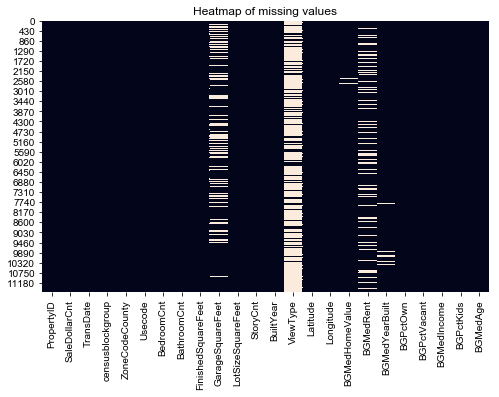

In [8]:
plt.subplots(figsize=(8,5))
plt.title('Heatmap of missing values')
sns.set(font_scale=1.25)
sns.heatmap(train.isnull(), cbar=False)

From the above results, we can find that there are 5 features with missing values. Three of them contain a large portion of missing values. They will be dealt with later.

## 2.2 Drop duplicate rows and redundant variables

In [9]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

There are not duplicated rows in the both train and test datasets. Next, redundant variables (variables that contain same value) are explored.

In [10]:
train.PropertyID.nunique() == train.shape[0]

True

In [11]:
train.columns[train.apply(lambda x: x.nunique() == 1)]

Index(['censusblockgroup', 'Usecode'], dtype='object')

'PropertyID' is unique for each row. There are two features that have the same value accross all rows, 'censusblockgroup' and 'Usecode'. These two columns along with 'PropertyID' are dropped below.

In [12]:
train = train.drop(['PropertyID', 'censusblockgroup', 'Usecode'], axis=1)

## 2.3 Exploring predicted variable - 'SaleDollarCnt'

First let's plot the distribution of sale prices.

[Text(0.5, 1.0, 'SalePrice distribution')]

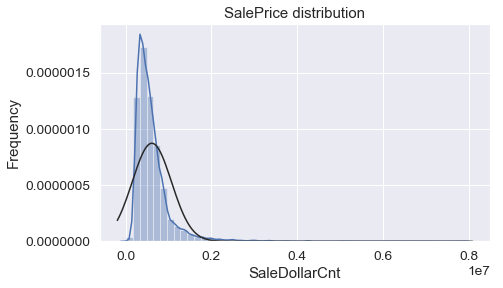

In [13]:
f, ax = plt.subplots(figsize=(7, 4))
sns.distplot(train['SaleDollarCnt'], fit=norm);
ax.set(ylabel="Frequency")
ax.set(xlabel="SaleDollarCnt")
ax.set(title="SalePrice distribution")

The black line in the above plot is normal distribution. We can see that the sale price is not normally distributed. Let's calculate its skewness and kurtosis.

In [14]:
print("Skewness: %f" % train['SaleDollarCnt'].skew())
print("Kurtosis: %f" % train['SaleDollarCnt'].kurt())

Skewness: 4.769303
Kurtosis: 41.220569


## 2.4 A deep dive to features
To explore further we will start with the following visualisation methods to analyze the data better:
* Correlation Heat Map
* Zoomed Heat Map
* Pair Plot
* Single plot - feature vs. sale price

### Heat map
First, let's plot the correlations between features using heat map.

Text(0.5, 1.0, 'Correlations between features')

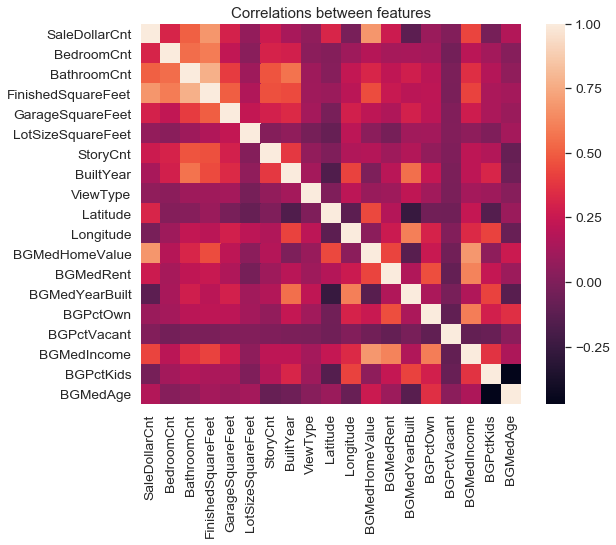

In [15]:
# correlation matrix
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(train.corr(),square=True).set_title('Correlations between features')

From the above heat map, we can find some of the features, such as 'FinishedSquareFeet', have higher correlations with sale price. Another observation is 'BathroomCnt' and 'FinishedSquareFeet' have a high correlation. 

### Zoomed heat map
Next, let's find the top ten highest correlations and plot the zoomed heat map.

In [16]:
# zoomed heatmap - selected variables
cols = train.corr().nlargest(10, 'SaleDollarCnt').index

Text(0.5, 1.0, 'Correlations with Sale Price (top 10)')

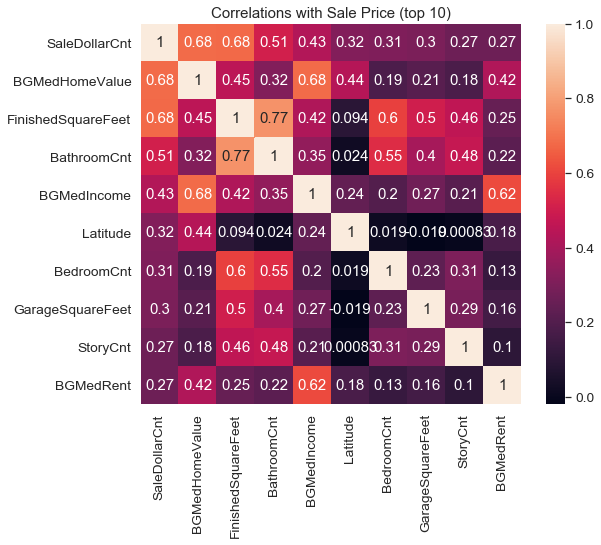

In [17]:
plt.subplots(figsize=(9,7))
sns.set(font_scale=1.25)
sns.heatmap(train[cols].corr(),square=True, annot=True).set_title('Correlations with Sale Price (top 10)')

The above heat map shows the ten features that have highest correlations with sale price. Some observations:
* 'BGMedHomeValue' and 'FinishedSquareFeet' are strongly correlated to sale price. 
* 'BathroomCnt' and 'FinishedSquareFeet' are highly correlated.
* 'BGMedIncome' and 'BGMedHomeValue' are also highly correlated.

### Pair plot
Next the pair plot between these 10 features was plotted.

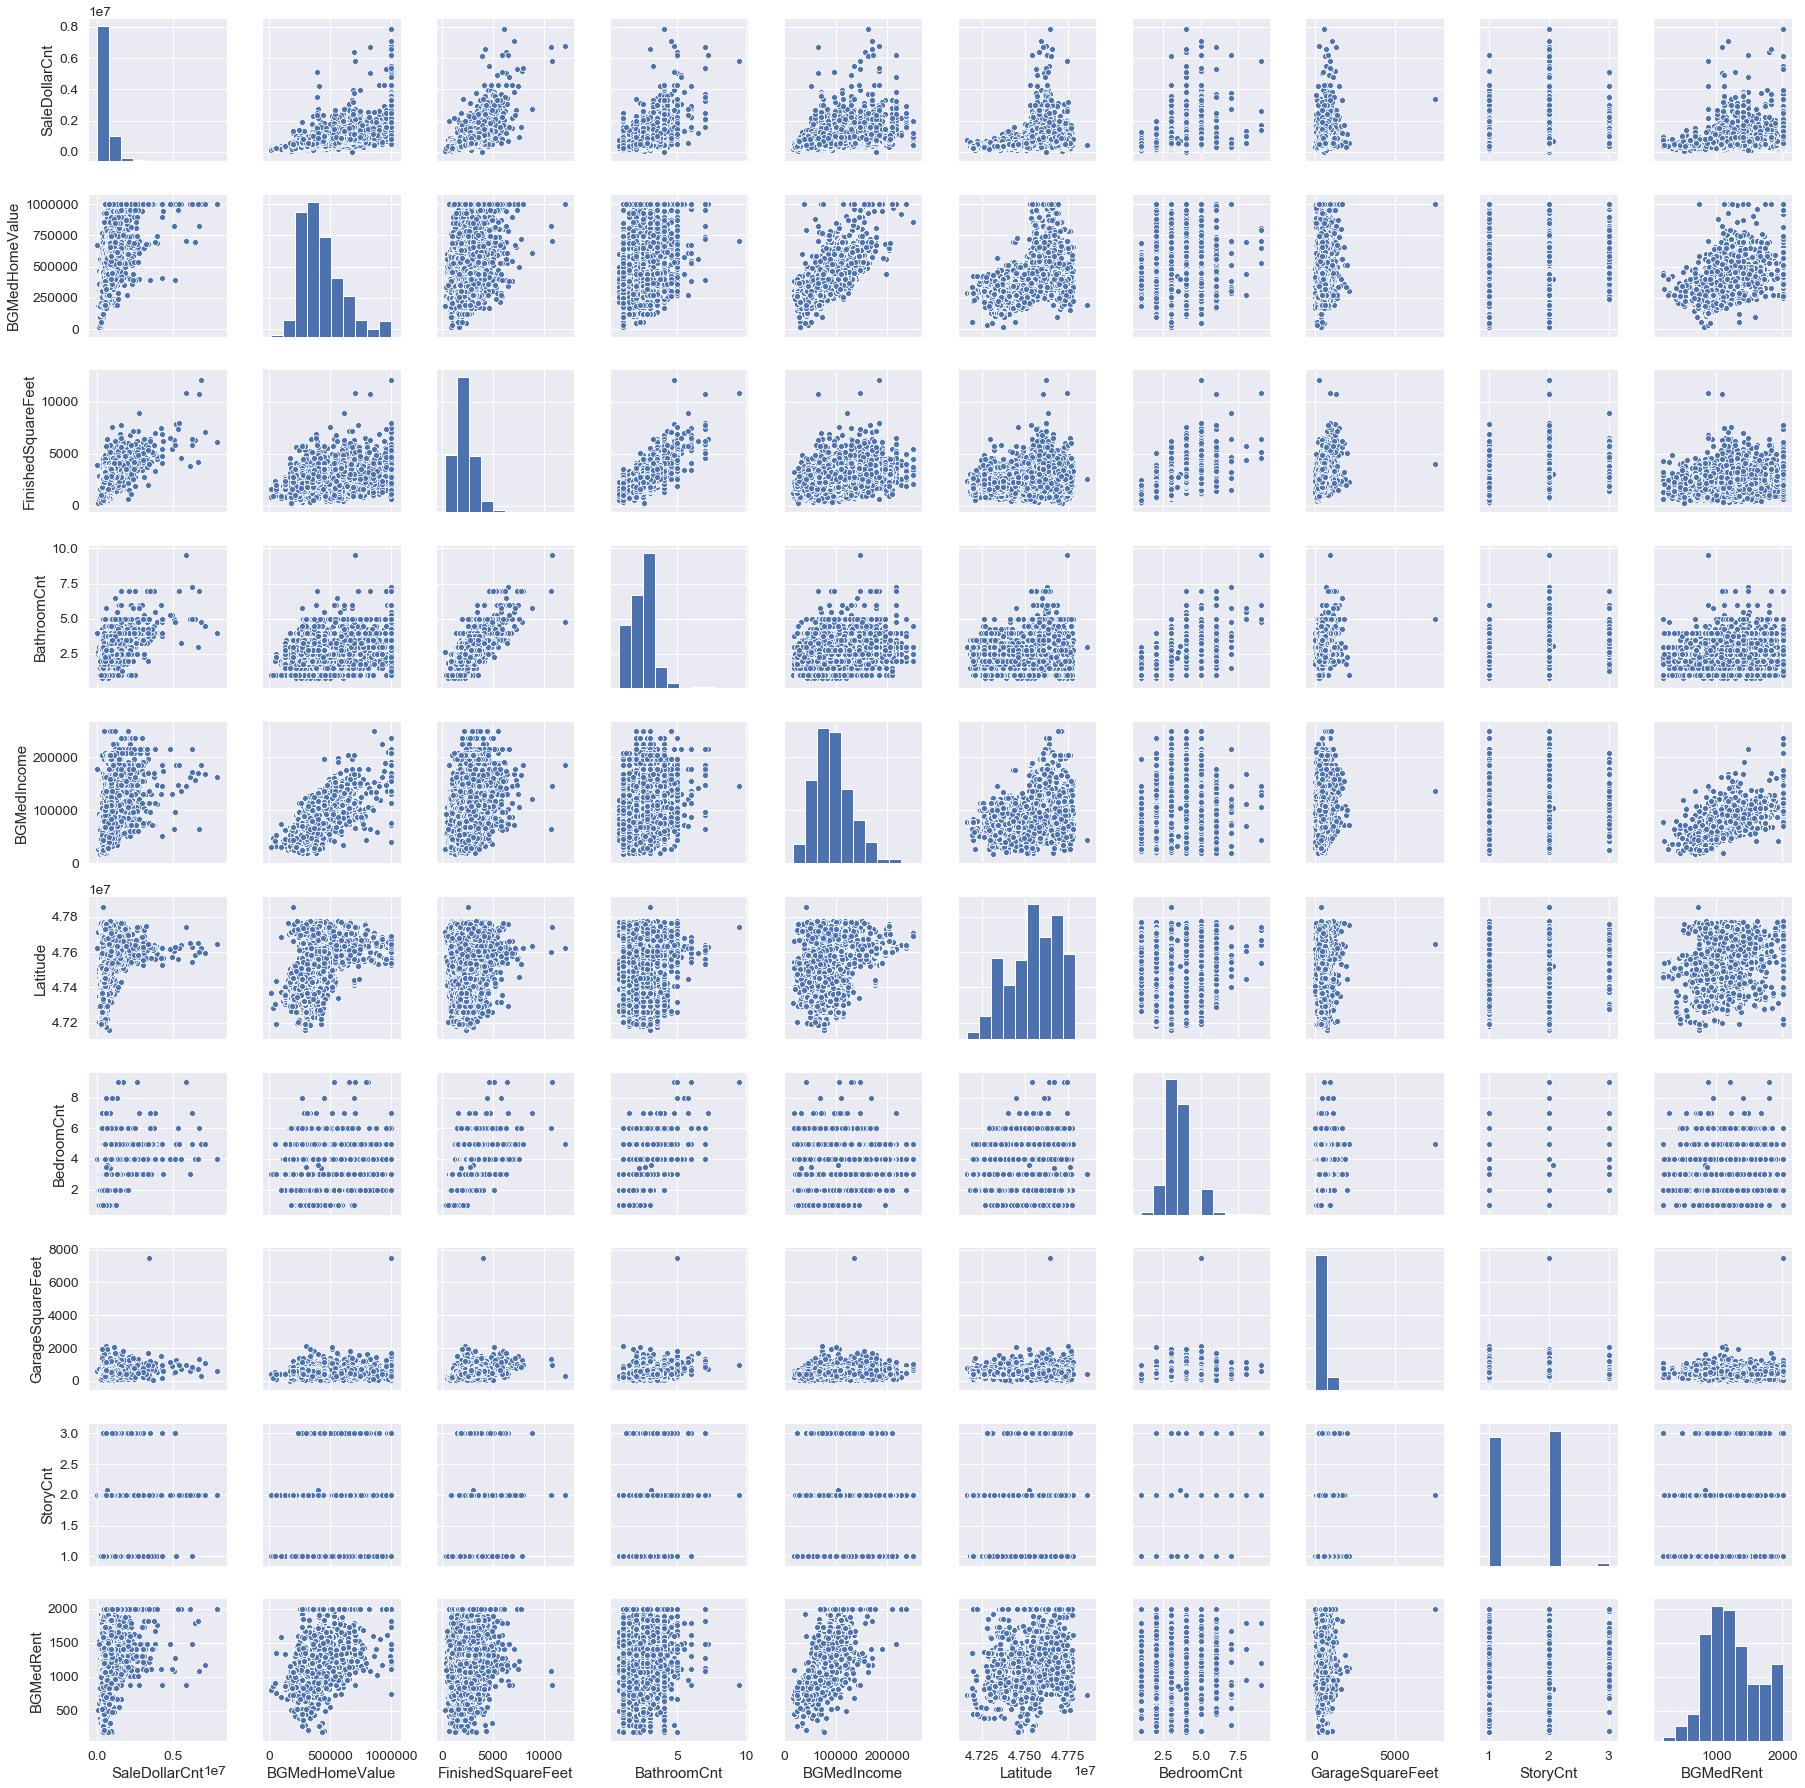

In [18]:
ax = sns.pairplot(train[cols])

Though we got correlation information from the heat map already, the pair plot gives us a better overview of the data. We can see the overall distribution of different features and we can identify some extreme values (outliers).

### Single plots - feature vs. sale price

Some single plots of relationship between interesting features and sale price are plotted below.

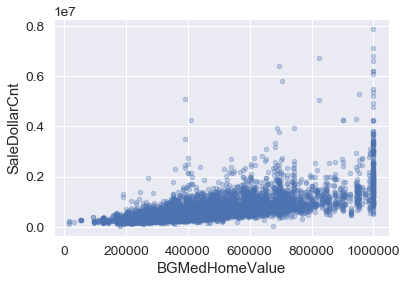

In [19]:
data = pd.concat([train['SaleDollarCnt'], train['BGMedHomeValue']], axis=1)
data.plot.scatter(x='BGMedHomeValue', y='SaleDollarCnt', alpha=0.3);

There is a clear positive correlation between 'BGMedHomeValue' and 'SaleDollarCnt'. However, the variance of 'SaleDollarCnt' is larger at high 'BGMedHomeValue'. If we zoom in the plot, the trend is more obvious.

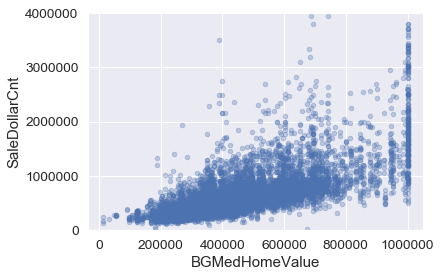

In [20]:
data.plot.scatter(x='BGMedHomeValue',y='SaleDollarCnt',alpha=0.3,ylim=(0,4e6));

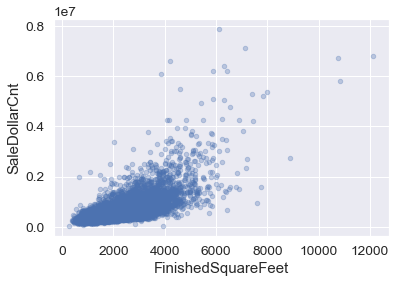

In [21]:
data = pd.concat([train['SaleDollarCnt'],train['FinishedSquareFeet']],axis=1)
data.plot.scatter(x='FinishedSquareFeet', y='SaleDollarCnt', alpha=0.3);

'FinishedSquareFeet' is also positively correlated with 'SaleDollarCnt'

From the pair plot, we can see that there is an outlier in 'GarageSquareFeet'. It be dealt with later.

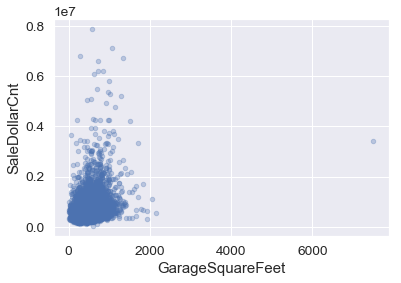

In [22]:
data = pd.concat([train['SaleDollarCnt'], train['GarageSquareFeet']], axis=1)
data.plot.scatter(x='GarageSquareFeet', y='SaleDollarCnt', alpha=0.3);

Surprisely, the year that the house was built was not correlated with sale price. 

Text(0.5, 1.0, 'Sale prices of houses built over years')

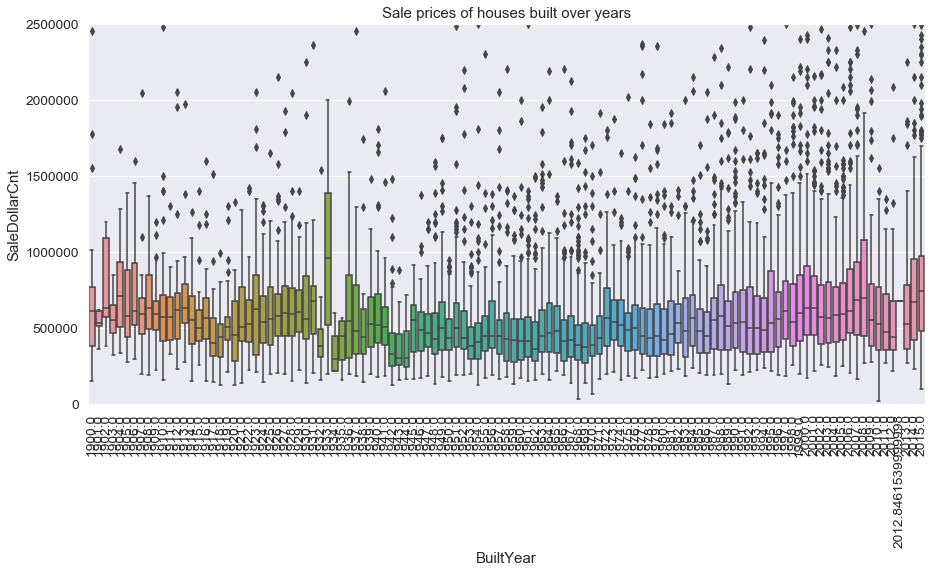

In [23]:
data = pd.concat([train['SaleDollarCnt'], train['BuiltYear']], axis=1)
f, ax = plt.subplots(figsize=(15, 7))
fig = sns.boxplot(x='BuiltYear', y='SaleDollarCnt', data=data)
fig.axis(ymin=0, ymax=2500000);
plt.xticks(rotation=90);
ax.set_title('Sale prices of houses built over years')

In [24]:
# change BuiltYear to int type
train['BuiltYear'] = train['BuiltYear'].apply(lambda x: int(x))

What about the date that the house was sold? The market could go up or down during given period of time.

In [25]:
train.TransDate = pd.to_datetime(train.TransDate)
print(min(train.TransDate), max(train.TransDate))
test.TransDate = pd.to_datetime(test.TransDate)
print(min(test.TransDate), max(test.TransDate))

2015-04-01 00:00:00 2015-09-30 00:00:00
2015-10-01 00:00:00 2016-01-01 00:00:00


Next, this period of time was binned into weeks. And we can plot the price change over weeks of give time.

Text(0.5, 1.0, 'Sale prices of houses over time')

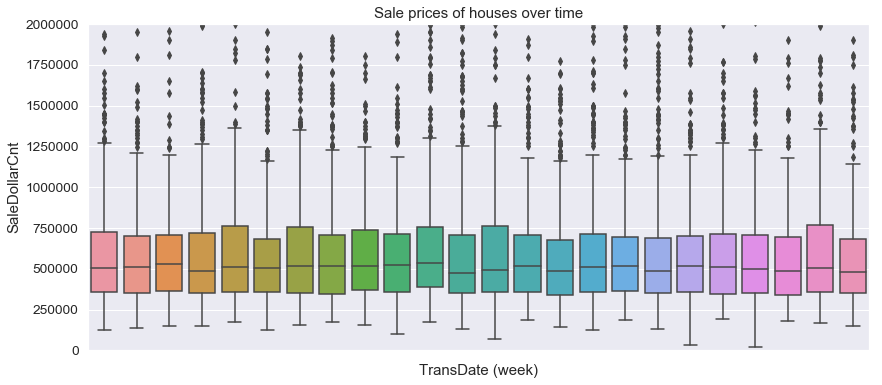

In [26]:
date_bin = pd.cut(train['TransDate'], bins=24)
data = pd.concat([train['SaleDollarCnt'], date_bin], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=date_bin, y="SaleDollarCnt", data=data)
fig.axis(ymin=0, ymax=2000000);
plt.xticks(rotation=45);
fig.set(xticklabels=[])
fig.set(xlabel='TransDate (week)')
ax.set_title('Sale prices of houses over time')

Some observations from the above output and plot:
* The sales prices did not change over the date of training data.
* The training data set was from '2015-04-01' to '2015-09-30', while the test data set was from '2015-10-01' to '2016-01-01'.
Since the date has no effect on sale price, and test set does not overlap with train set, we can drop this feature later.

### Location

It is commonly accepted that the location plays an important role in real estate. Here the latitude and longitude of each house are provided. Firstly, let's visulize the relationship between location and house price.

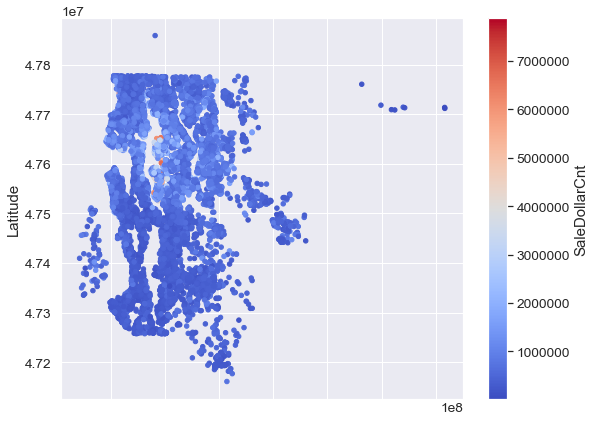

In [27]:
train.plot.scatter(x='Longitude', y='Latitude', c='SaleDollarCnt', colormap='coolwarm', figsize=(9, 7))

As we can see from above plot, the upper middle part of the county has higher price.

# 3 Feature engineering

## 3.1 Fill missing values

As we discussed in section 2.1, there are four features with missing values. Three of them have a large portion.

In [28]:
pd.concat([missing_count, missing_percentage], axis=1, keys=['missing_count','missing_percentage %'])

,missing_count,missing_percentage %
ViewType,8956,77.29
GarageSquareFeet,2841,24.52
BGMedRent,2631,22.70
BGMedYearBuilt,247,2.13
BGMedHomeValue,6,0.05


### ViewType
Since the missing values in 'ViewType' indicate there is no view, we can fill the missing values of 'ViewType' with 0. And we should be careful here, ViewType contains numeric values, but it is not numeric feature. It was converted to string later.

In [29]:
train['ViewType'] = train['ViewType'].fillna(0)

### GarageSquareFeet
Missing values in 'GarageSquareFeet' indicate there is no garage, we can fill the missing values with 0.

In [30]:
train['GarageSquareFeet'] = train['GarageSquareFeet'].fillna(0)

### BGMedRent, BGMedYearBuilt and BGMedHomeValue
Since 'BGMedRent', 'BGMedYearBuilt' and 'BGMedHomeValue' describe the median values of a home in the bloack group. We can fill the missing values with same value in that block. However, we don't have information that which block the house is. One way to fill them is using the closest house with known value based on the location. I take advantage of K Nearest Neighbors regressor and set K=1. 

In [31]:
def fill_by_neighbor(data, location_feature, target_feature):
    idx = data[target_feature].isnull()
    x = data.loc[~idx, location_feature]
    y = data.loc[~idx, target_feature]
    model = KNeighborsRegressor(1)
    model.fit(x,y)
    data.loc[idx, target_feature] = model.predict(data.loc[idx, location_feature])

for feature in ['BGMedRent', 'BGMedYearBuilt', 'BGMedHomeValue']:
    fill_by_neighbor(train, ['Latitude', 'Longitude'], feature)

In [32]:
train.columns[train.isnull().sum() != 0]

Index([], dtype='object')

All the missing values were filled already.

## 3.2 Remove outliers

From plots in section 2.4, we can see there is one extreme value of 'GarageSquareFeet'. Let's remove it from the data set.

In [33]:
train = train.drop(train[train['GarageSquareFeet'] > 5000].index)
train.reset_index(drop=True, inplace=True)

## 3.3 Drop unnecessary features
As we dissussed above, 'TransDate' minorly affects the sale price, it can be dropped from the data set. And 'ZoneCodeCounty' has over 100 unique values, we can also drop it.

In [34]:
print(train['ZoneCodeCounty'].nunique())
train = train.drop(['TransDate', 'ZoneCodeCounty'], axis=1)

178


## 3.4 Enocode categorical features

The feature 'ViewType' is non-numeric, however, it was stored as numbers. Let's convert it to string and then encode it.

In [35]:
train['ViewType'] = train['ViewType'].apply(lambda x: 1 if x==241 or x==247 else x) # combine two minor types
train['ViewType'] = train['ViewType'].apply(str)
train = pd.get_dummies(train).reset_index(drop=True)

## 3.5 Log-transform dependent variable

The evaluation metric is average absolute percent error (AAPE), one way to incorporate this is to customize the loss function. Alternatively, we can do log transform on dependent variable and evaluate the Mean absolute error (MAE) on the log-transformed values. This will give us a close estimation to AAPE.

In [36]:
train['SaleDollarCnt'] = np.log(train['SaleDollarCnt'])
train['SaleDollarCnt'].skew(), train['SaleDollarCnt'].kurt()

(0.6206100822542567, 1.1573338465465262)

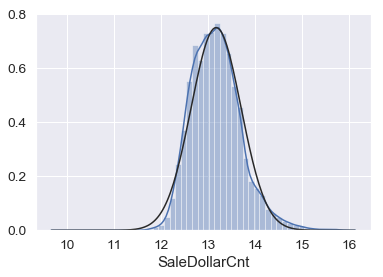

In [37]:
#transformed histogram and normal probability plot
sns.distplot(train['SaleDollarCnt'], fit=norm);

# 4 Apply same protocol on test set

In [38]:
PropertyID = test['PropertyID'] # Save ID for later usage
test = test.drop(['PropertyID', 'censusblockgroup', 'Usecode','TransDate', 
                  'ZoneCodeCounty', 'SaleDollarCnt'], axis=1)
test['BuiltYear'] = test['BuiltYear'].apply(lambda x: int(x) if x==x else "")

# Check missing values in test set
missing_count = test.isnull().sum().sort_values(ascending = False)\
                [test.isnull().sum().sort_values(ascending = False) != 0]
missing_percentage = round(test.isnull().sum().sort_values(ascending = False)/len(train)*100,2)[round(test.isnull().sum().sort_values(ascending = False)/len(train)*100,2) != 0]
pd.concat([missing_count, missing_percentage], axis=1,
          keys=['missing_count','missing_percentage'])

,missing_count,missing_percentage
ViewType,3404,29.38
GarageSquareFeet,1138,9.82
BGMedRent,963,8.31
BGMedYearBuilt,62,0.54
BGMedHomeValue,7,0.06


We got the same features that contain missing values. Now, the same precedure will be applied.

In [39]:
# Fill missing values
test['ViewType'] = test['ViewType'].fillna(0)
test['GarageSquareFeet'] = test['GarageSquareFeet'].fillna(0)
for feature in ['BGMedRent', 'BGMedYearBuilt', 'BGMedHomeValue']:
    fill_by_neighbor(test, ['Latitude', 'Longitude'], feature)

# Encode categorical feature
test['ViewType'] = test['ViewType'].apply(lambda x: 1 if x==241 or x==247 else x)
test['ViewType'] = test['ViewType'].apply(str)
test = pd.get_dummies(test).reset_index(drop=True)

# 5 Training model
Three models was trained and explored here. They are:
* Lasso Regression
* Ridge Regression
* XGBoost - Tree based ensemble model

First, the training set was further split into train and test sets. Train set was used for parameter selection and test set was used for evaluating performance.

For each model, GridSearchCV was used to find the optimal hyperparameters by grid searching. To evaluate the performance of each model, the best estimator found from grid searching were applied on predicting the test set.

In [40]:
y = train['SaleDollarCnt']
X = train.drop('SaleDollarCnt', axis=1)
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 5.1 Lasso regression

In [41]:
params_lasso = {'alpha': [5e-5,1e-4,2e-4,5e-4,1e-3]}
lasso = Lasso(random_state=42)

gd_lasso = GridSearchCV(estimator=lasso, 
                   param_grid=params_lasso,
                   scoring="neg_mean_absolute_error",
                   n_jobs=-1,
                   cv=5)

gd_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [5e-05, 0.0001, 0.0002, 0.0005, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [42]:
# Print best score and best params, save the best estimator
print(gd_lasso.best_score_)
print(gd_lasso.best_params_)
lasso_cv = gd_lasso.best_estimator_

-0.1549722621740436
{'alpha': 0.0002}


## 5.2 Ridge regression

In [43]:
params_ridge = {'alpha': [0.0001,0.001,0.01,0.1, 1]}
ridge = Ridge(random_state=42)

gd_ridge = GridSearchCV(estimator=ridge, 
                   param_grid=params_ridge,
                   scoring="neg_mean_absolute_error",
                   n_jobs=-1,
                   cv=5)

gd_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [44]:
# Print best score and best params, save the best estimator
print(gd_ridge.best_score_)
print(gd_ridge.best_params_)
ridge_cv = gd_ridge.best_estimator_

-0.15508848231012093
{'alpha': 1}


## 5.3 XGBoost

In [45]:
xgb = XGBRegressor(learning_rate=0.01, 
                   n_estimators=1000, 
                   gamma=0.1, 
                   subsample=0.9,
                   reg_alpha=1,
                   reg_lambda=1, 
                   colsample_bytree=0.6,
                   nthread=4,
                   seed=42)

params_xgb = {'max_depth' : range(4,8,1), 'min_child_weight' : range(1,3,1)}

gd_xgb = GridSearchCV(estimator = xgb,
                       param_grid = params_xgb, 
                       scoring="neg_mean_absolute_error", 
                       n_jobs=-1,
                       cv=5)

gd_xgb.fit(X_train, y_train)

[15:19:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.6, gamma=0.1,
                                    importance_type='gain', learning_rate=0.01,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=1, nthread=4,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=1, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=0.9, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(4, 8),
                         'min_child_weight': range(1, 3)},
             pre_disp

In [46]:
# Print best score and best params, save the best estimator
print(gd_xgb.best_score_)
print(gd_xgb.best_params_)
xgb_cv = gd_xgb.best_estimator_

-0.11679439946999752
{'max_depth': 7, 'min_child_weight': 2}


# 6 Evaluate performances of models
For Lasso regression and Ridge regression, the train data was directly fitted by the best estimators obtained above. 

In [47]:
# Define evaluation metric - MAE
def error(model):
    y_test_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_test_pred)

lasso_model = lasso_cv.fit(X_train, y_train)
ridge_model = ridge_cv.fit(X_train, y_train)

Errors = {}
Errors['Lasso'] = error(lasso_model)
Errors['Ridge'] = error(ridge_model)

For XGBoost, to avoid overfitting, early stopping was implemented. The training process will be terminated if the error hasn't improved in 10 rounds. The errors of both train and test data were recorded during this process, and then plotted.

In [48]:
# specify the metric to be MAE
xgb_final = XGBRegressor(max_depth=7, 
                     min_child_weight=1, 
                     gamma=0.1,
                     learning_rate=0.01, 
                     max_delta_step=0,
                     n_estimators=3000,
                     nthread=4,
                     reg_alpha=1, 
                     reg_lambda=1, 
                     random_state=42,
                     eval_metric='mae')

In [49]:
# Specify evaluation set to be both train and test 
eval_set=[(X_train, y_train), (X_test, y_test)]
xgb_final.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=200)

[15:19:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:12.54	validation_1-mae:12.5376
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[200]	validation_0-mae:1.68345	validation_1-mae:1.68087
[400]	validation_0-mae:0.241103	validation_1-mae:0.242426
[600]	validation_0-mae:0.111697	validation_1-mae:0.121933
[800]	validation_0-mae:0.10061	validation_1-mae:0.114931
[1000]	validation_0-mae:0.095626	validation_1-mae:0.11249
[1200]	validation_0-mae:0.092676	validation_1-mae:0.111396
Stopping. Best iteration:
[1225]	validation_0-mae:0.092372	validation_1-mae:0.111306



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
             gamma=0.1, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=3000, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=42, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

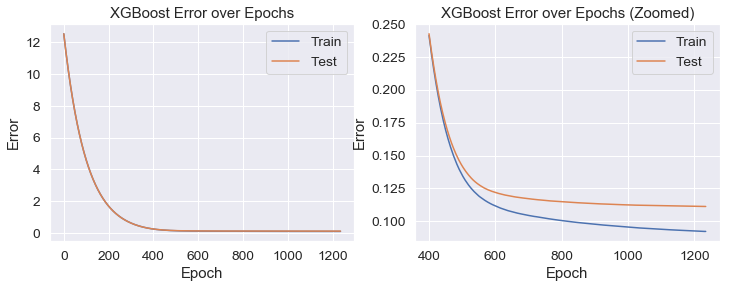

In [50]:
results = xgb_final.evals_result()
epochs = len(results['validation_0']['mae'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
x_axis_1 = range(0, epochs)
x_axis_2 = range(400, epochs)
ax1.plot(x_axis_1, results['validation_0']['mae'], label='Train')
ax1.plot(x_axis_1, results['validation_1']['mae'], label='Test')
ax2.plot(x_axis_2, results['validation_0']['mae'][400:], label='Train')
ax2.plot(x_axis_2, results['validation_1']['mae'][400:], label='Test')
for ax in (ax1,ax2):
    ax.set(xlabel='Epoch', ylabel='Error')
    ax.legend()
ax1.set_title('XGBoost Error over Epochs')
ax2.set_title('XGBoost Error over Epochs (Zoomed)')
plt.show()

The above two plots can help us on better error analysis. The left plot was the error on train and test during the whole training process before stopping. Since the train error and test error are close, they are overlapped. For better visalization, the right plot was zoomed in and focused on late epochs. We can see that both train error and test error stablized and the training process stopped after 1200th epoch.

In [51]:
# The errors of different models on predicting test set are stored in Errors
Errors['XGBoost'] = results['validation_1']['mae'][-1]
Errors

{'Lasso': 0.15213975051429343,
 'Ridge': 0.15219099478243933,
 'XGBoost': 0.111306}

XGBoost has better performance compared to Lasso and Ridge regression. It was chose as the final estimator. Before the final prediction, let's take a look at the most important features. 

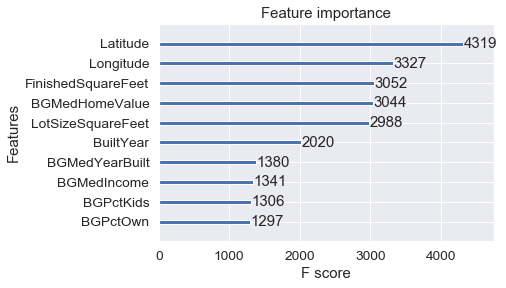

In [52]:
plot_importance(xgb_final, max_num_features=10)

The location of the home is the most important feature. Besides location, the median home value of the block, lot size and finished size also have large impact on price.

# 7 Make final prediction
Since the predicted variable was log transformed first, we need to transform it back after prediction.

In [53]:
y_pred = np.exp(xgb_final.predict(test))
results = pd.DataFrame(columns=['PropertyID', 'SaleDollarCnt'])
results['PropertyID'] = PropertyID
results['SaleDollarCnt'] = y_pred
results.to_csv('results.csv', header=True, index=False)

# 8 Next steps

In the current model, only minor feature engineering was done. In the future, after gaining more knowledge on real estate, more complicated features can be come up with. For example, in this data set, the latitude and longitude of house are the most important features. We can creat new location features, such as neighborhood, by geocoding. 

The feature 'ZoneCodeCounty' has more than 170 categorical levels, so I dropped it in the model training. If more time and computation power allowed, I can encode this feature. Another good idea to avoid so many levels is group them into less levels by knowledge on the feature itself. 

Two simple linear regression models and one tree based ensemble model were trained. XGBoost regressor gives us better performance. More different types of models, such as SVR, KNN, Random Forest can be trained. We could also try to train more different models, and blend the predictions by summing up weighted predictions. This approach may help to reduce the prediction error.